### `import` Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import style

style.use('seaborn-deep')

In [ ]:
folder_path = '/content/drive/MyDrive/AAIC/QQP/'

### Data Reading

In [ ]:
df = pd.read_csv(folder_path + 'train.csv')

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# EDA

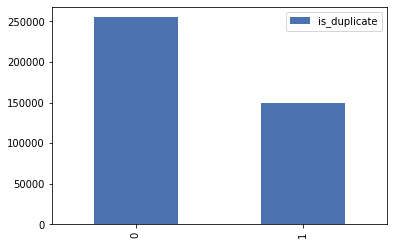

In [ ]:
dup_counts = df['is_duplicate'].value_counts().to_frame()
dup_counts.plot(kind='bar')

In [ ]:
percentage_vals = dup_counts.apply(lambda x : round(((x / df.shape[0]) * 100), 2))
dup_counts['percetange'] = percentage_vals
dup_counts

,is_duplicate,percetange
0,255027,63.08
1,149263,36.92


The output (target) feature is binary in nature. Therefore it is a binary classification problem where $y_i \in \{0, 1\}$.

* We do not want the out to be just in `1` and `0`.

* We actually have to care about the probability value and by setting a threshold, we can be able to classify the questions.

$$P(Q_1 \simeq Q_2) \rightarrow \{0, 1\}$$

* Whenever we have a probability value, `log-loss` is one of the best metrics to evaluate the model performance.

* Binary confusion matrix.

### Number of Unique Questions

In [ ]:
list(df.columns)

['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']

In [ ]:
all_questions = pd.Series(df['qid1'].to_list() + df['qid2'].to_list())
print('Total number of questions are : {}'.format(len(all_questions)))

unique_questions = list(set(all_questions))
unique_question_len = len(unique_questions)
print('Total unique questions are : {}'.format(unique_question_len))

question_freq = all_questions.value_counts().to_frame()
print('Max number of times a single question is repeated : {}'.format(question_freq.iloc[0].values[0]))

repeatative_questions = np.sum(np.where((question_freq[0] != 1), 1, 0))
print("Total number of questions that repaeat more than once : {}".format(repeatative_questions))

non_repeatative_questions = unique_question_len - repeatative_questions
print("Total number of questions that do not repaeat more than once : {}".format(non_repeatative_questions))

Total number of questions are : 808580
Total unique questions are : 537933
Max number of times a single question is repeated : 157
Total number of questions that repaeat more than once : 111780
Total number of questions that do not repaeat more than once : 426153


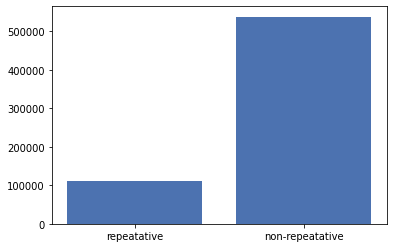

In [ ]:
x_ = ['repeatative', 'non-repeatative']
y_ = [repeatative_questions, unique_question_len]
plt.bar(x_, y_)
plt.show()

### Check for Duplicates

In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [ ]:
df.duplicated(['qid1', 'qid2']).sum()

0

### Question Occurrence

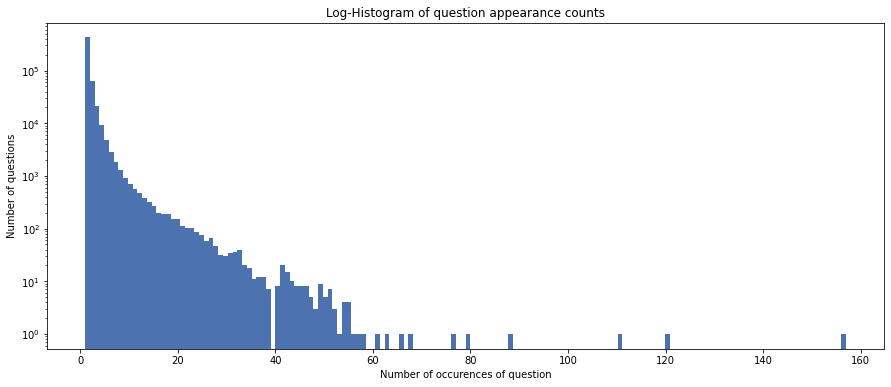

Maximum number of times a single question is repeated: [157]


In [ ]:
plt.figure(figsize=(15, 6))

qvals = question_freq.values
plt.hist(qvals, bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

print ('Maximum number of times a single question is repeated: {}'.format(max(qvals))) 

### Check for `NaN` values

In [ ]:
def get_nan_indices(dframe):
    """
    dframe → pandas data frame object
    returns `nan_places` a dictionary of column names and the `nan_indices`
    """
    nan_places = {}
    
    for col in dframe.columns:
        indices = list(np.where(dframe[col].isnull())[0])
        nan_places[col] = indices
    
    return nan_places

In [ ]:
get_nan_indices(dframe=df)

{'id': [],
 'is_duplicate': [],
 'qid1': [],
 'qid2': [],
 'question1': [363362],
 'question2': [105780, 201841]}

In [ ]:
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


### Fill with `space`

In [ ]:
df = df.fillna('')

### Basic Feature Extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
strip_with_lower = lambda word : word.lower().strip()
strip_with_lower_seq = lambda word_list : list(map(strip_with_lower, word_list))

separate_words = lambda question : question.split(" ")
count_words = lambda question : len(question.split(" "))

common_words = lambda qq : 1.0 * len(qq[0] & qq[1])
total_words = lambda qq : 1.0 * (len(qq[0]) + len(qq[1]))
words_share = lambda qq : 1.0 * (len(qq[0] & qq[1]) / (len(qq[0]) + len(qq[1])))

sum_q1q2 = lambda qq : sum(qq)
abs_q1q2 = lambda qq : abs(qq[0] - qq[1])

In [ ]:
class QuestionFeatureExraction:
    def __init__(self, df, new_filename=None):
        self.df = df
        self.new_filename = new_filename

        self.word_set_q1 = self.get_words_set(col_name='question1')
        self.word_set_q2 = self.get_words_set(col_name='question2')
        self.word_set_q1q2 = list(zip(self.word_set_q1, self.word_set_q2))
    
    def get_freq(self, col_name):
        freq_val = self.df.groupby(col_name)[col_name].transform('count').to_list()
        return freq_val
    
    def get_str_len(self, col_name):
        len_val = self.df[col_name].str.len().to_list()
        return len_val
    
    def get_words_count(self, col_name):
        word_count = self.df[col_name].apply(count_words).to_list()
        return word_count
    
    def get_words_set(self, col_name):
        q = self.df[col_name].apply(separate_words)
        word_set = list(map(set, list(map(strip_with_lower_seq, q))))
        return word_set
    
    def get_common_words(self):
        return list(map(common_words, self.word_set_q1q2))
    
    def get_total_words(self):
        return list(map(total_words, self.word_set_q1q2))
    
    def get_word_share_ratio(self):
        return list(map(words_share, self.word_set_q1q2))
    
    def get_op_freq_q1q2(self, col_name1, col_name2, op='sum'):
        freq_q1 = self.get_freq(col_name=col_name1)
        freq_q2 = self.get_freq(col_name=col_name2)
        freq_q1q2 = list(zip(freq_q1, freq_q2))
        
        if (op == 'sum'):
            return list(map(sum_q1q2, freq_q1q2))
        return list(map(abs_q1q2, freq_q1q2))

In [ ]:
if os.path.isfile(folder_path + 'df_fe_without_preprocessing_train.csv'):
    print("Found in the folder")
    df = pd.read_csv(folder_path + 'df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    print("Staring the process")
    qfe = QuestionFeatureExraction(df=df)

    df['freq_qid1'] = qfe.get_freq(col_name='qid1')
    df['freq_qid2'] = qfe.get_freq(col_name='qid2')

    df['q1len'] = qfe.get_str_len(col_name='question1')
    df['q2len'] = qfe.get_str_len(col_name='question2')

    df['q1_n_words'] = qfe.get_words_count(col_name='question1')
    df['q2_n_words'] = qfe.get_words_count(col_name='question2')

    df['word_Common'] = qfe.get_common_words()
    df['word_Total'] = qfe.get_total_words()
    df['word_share'] = qfe.get_word_share_ratio()

    df['freq_q1+q2'] = qfe.get_op_freq_q1q2(col_name1='question1', col_name2='question2', op='sum')
    df['freq_q1-q2'] = qfe.get_op_freq_q1q2(col_name1='question1', col_name2='question2', op='abs')

    df.to_csv(folder_path + 'df_fe_without_preprocessing_train.csv', index=False)

df.head()

Found in the folder


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Analysis on the extracted features

In [ ]:
print("Minimum length of the questions in question1 : ", min(df['q1_n_words']))
print("Minimum length of the questions in question2 : ", min(df['q2_n_words']))

print("Number of Questions with minimum length [question1] : ", df[df['q1_n_words'] == 1].shape[0])
print("Number of Questions with minimum length [question2] : ", df[df['q2_n_words'] == 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] :  67
Number of Questions with minimum length [question2] :  24


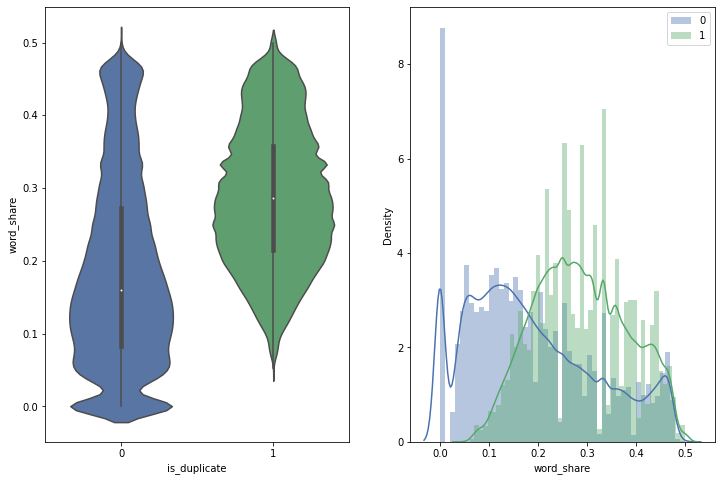

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_share', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label='0')
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label='1')

plt.legend()
plt.show()

- The distributions for normalized `word_share` have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.

- The average word share and Common no. of words of `qid1` and `qid2` is more when they are duplicate (similar).

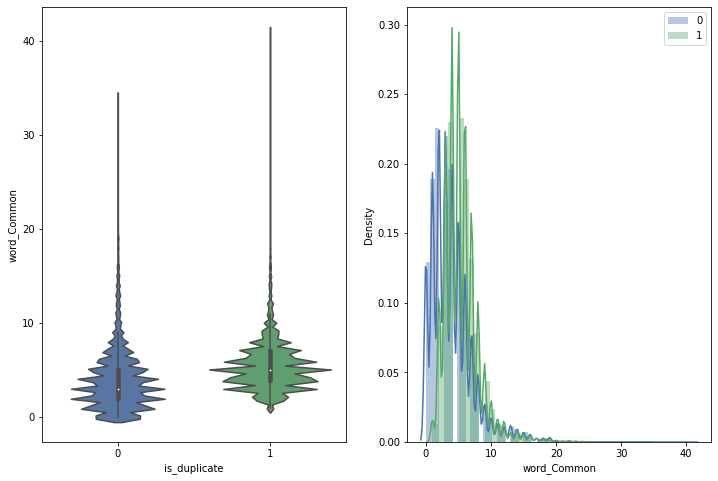

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:], label='0')
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:], label='1')

plt.legend()
plt.show()

The distributions of the `word_Common` feature in similar and non-similar questions are highly overlapping.

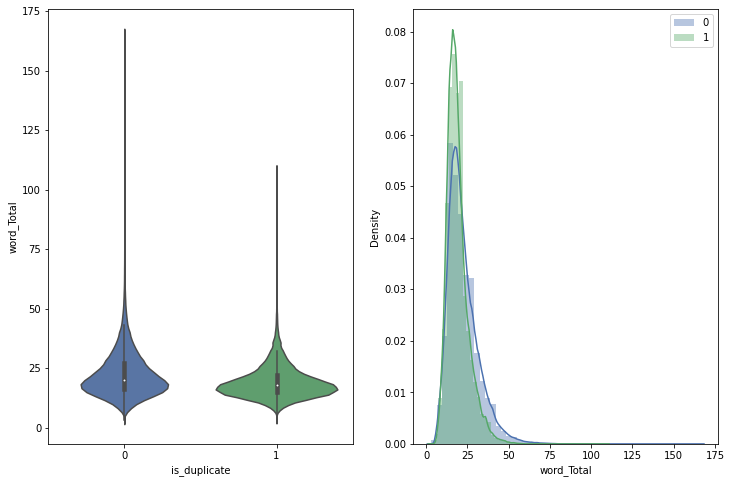

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_Total', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:], label='0')
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:], label='1')

plt.legend()
plt.show()

The distributions of the `word_Total` feature in similar and non-similar questions are highly overlapping.